# PEAK DETECTION ALGORITHM WITH FUNCTION FROM: myown_paper

In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import math
import statistics
import neurokit2 as nk
from scipy.signal import butter, filtfilt, iirnotch, savgol_filter
import scipy.signal
import peakutils.peak
import seaborn as sns

In [6]:
def butter_lowpass(cutoff, sample_rate, order=2):
    """
    The function returns the butter indexes for a butter lowpass filter. Github https://github.com/paulvangentcom/heartrate_analysis_python/tree/0005e98618d8fc3378c03ab0a434b5d9012b1221 
    
    Input: cutoff-frequency from which the values will be filtered out; order-stregnth of the filter; sample_rate-rate at which the signal was sampled.
    
    Ouput: butter indeces.

    """
    nyq = 0.5 * sample_rate
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_highpass(cutoff, sample_rate, order=2):
    """
    The function returns the butter indexes for a highpass filter. Github https://github.com/paulvangentcom/heartrate_analysis_python/tree/0005e98618d8fc3378c03ab0a434b5d9012b1221 
    
    Input: cutoff-frequency from which the values will be filtered out; order-stregnth of the filter; sample_rate-rate at which the signal was sampled.
    
    Ouput: butter indeces.

    """
    nyq = 0.5 * sample_rate
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

In [7]:
def filter_signal(data, cutoff, sample_rate, order=2, filtertype='lowpass'):
    """
    The function filters data in the frequency domain. 
    
    Input: data-signal data stored in an array; cutoff-frequency from which the values will be filtered out; order-stregnth of the filter; filtertype-type of filter:
        lowpass,highpass,bandpass,notch
    
    Ouput: filtered_data

    """
    
    if filtertype.lower() == 'lowpass':
        b, a = butter_lowpass(cutoff, sample_rate, order=order)
    elif filtertype.lower() == 'highpass':
        b, a = butter_highpass(cutoff, sample_rate, order=order)
    elif filtertype.lower() == 'bandpass':
        assert type(cutoff) == tuple or list or np.array, 'if bandpass filter is specified, \
cutoff needs to be array or tuple specifying lower and upper bound: [lower, upper].'
        b, a = butter_bandpass(cutoff[0], cutoff[1], sample_rate, order=order)
    elif filtertype.lower() == 'notch':
        b, a = iirnotch(cutoff, Q = 0.005, fs = sample_rate)
    else:
        raise ValueError('filtertype: %s is unknown, available are: \
lowpass, highpass, bandpass, and notch' %filtertype)

    filtered_data = filtfilt(b, a, data)
    
    return filtered_data

In [8]:
def remove_baseline_wander(data, sample_rate, cutoff=0.05):
    """
    The functions removes the signal's baseline.
    Input: data-signal stored in an array; sample_rate: sample rate in which the signal was sampled; cutoff-frequency frequency from which the values will be filtered out.
    Output: corrected signal.
    """
    return filter_signal(data = data, cutoff = cutoff, sample_rate = sample_rate,
                         filtertype='notch')

In [9]:
def cos_correction(signal):
    """
    The function removes a tenth of both ends from the signal by multiplying it by a half cosine function.
    Input: signal-index of data points to be corrected.
    Output: even signal with the corners diminished. 
    """
    length = len(signal) # We find the length of the signal.
    signal_10 = 0.01*length # We calculate the length of a tenth of the signal.
    signal_90 = length - signal_10 # We calculate the difference to know the tenth corresponding to the array's final end.
    step = (np.pi/2)/signal_10 # We find the number of values our cosine function needs to have.

    x = np.arange(0,np.pi/2,step) # We generate half a cosine function: start,stop,step
    y = np.cos(x)
    cos_end = y

    y = np.cos(x-1.57) # We shift it by pi so we can use it as a smoothening factor to apply to the values at the end of the signal.
    cos_init = y

    for index,value in enumerate(cos_init):
        signal[index] = signal[index]*value # We perform the multiplicatoin by the signal points and the cosine points.

    for value, index in zip((signal[int(signal_90):]), cos_end):
        signal[int(-index)] = value * index
    return signal

In [10]:
def scale_data(data, lower=0, upper=1024):
    """
    Subfunction from the enhance_peaks section. It allows to scale the data.
    Input: data-the signal, lower,upper-ranges that describe the scaling factor.
    Output: scaled signal. 
    """
    rng = np.max(data) - np.min(data)
    minimum = np.min(data)
    data = (upper - lower) * ((data - minimum) / rng) + lower
    return data

In [11]:
def enhance_peaks(hrdata, iterations=2):
    """
    The function squares the signal and, hence, enhances the peaks.
    Input: hrdata-the signal stored in an array; iterations-the times the signal is squared.
    Output: enhanced signal. 
    """
    scale_data(hrdata)
    for i in range(iterations):
        hrdata = np.power(hrdata, 2)
        hrdata = scale_data(hrdata)
    return hrdata 

In [12]:
def smoothing_window(signal):
    """
    The function creates a sliding window and it is used to smooth the signal out by an average mean.
    Input: signal-the signal stored in an array.
    Output: smoothened signal. 
    """
    #Define window size
    w=31
    #Define mask and store as an array
    mask=np.ones((1,w))/w
    mask=mask[0,:]

    #Convolve the mask with the raw data
    convolved_data=np.convolve(signal,mask,'same')
    return convolved_data

In [140]:
def _filtering(signal,rate):
    """
    Application of a sub-sequent filtering steps, based on the Pan-Tomkins peak scalation for subsequent peak detection. 
    Input: signal-the signal stored in an array; rate-the sampling frequency at which the signal was sampled.
    Output: filtered signal. 
    """
    cos_removed = cos_correction(signal) # We remove the points located at both ends of the signal.
    low = filter_signal(cos_removed,40, rate, order=3, filtertype='lowpass') # We apply a low-pass filter.
    high = filter_signal(low,5, rate, order=3, filtertype='highpass') # We apply a high-pass filter.
    smooth = smoothing_window(high) # We smooth the data.
    notch = filter_signal(smooth, 50, rate, filtertype='notch') # We apply a notch filter.
    remove = remove_baseline_wander(notch, rate) # We remove the signal's baseline.
    en = enhance_peaks(remove, iterations=4) # We enhance the signal twice to improve the following peak-detection.
    return en

In [170]:
def _peakdetection(signal):
    
    """
    
    The funtion detects the peaks based on a threshold algorithm described in the following paper:
    https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7922324/. The algorithm has been tunned to incorporate a sliding threshold
    that accounts for enhanced peaks. 
    
    Input: signal-the signal we would like to obtain the peaks from.
    Output: a dataframe containing the x and y values corresponding to the different peaks detected.
    
    """
    
    peaks = pd.DataFrame()
    y_points = [] # List where we are going to store the y_values of the peaks detected.
    x_points = [] # List where we are going to store the x_values of the peaks detected.
    temp = 0.5*((0.75*np.percentile(signal, 90))+(0.25*np.mean(signal))) #+ np.std(signal) # We define the threshold.
    for index,point in enumerate(signal): 
        if point > temp: # We check if the value is bigger than the threshold. If it is the case, we set it as the new threshold.
            threshold = point
            if signal[index+1]< threshold and (signal[index]-signal[index-1]) > 0: # If the next value is lower than the threshold, then we add the point as detected and we restart the threshold.
                y_points.append(point) # We add the difference between the values because the first condition will detect all the points on the QRS complex, we need to not save the lower points on the peak's slope.
                x_points.append(index)
        if point < temp: # Once the peak is stored, we restart the threshold value to calculate the following peak.
            threshold = temp
    
    peaks['x_values'] = x_points
    peaks['y_values'] = y_points
    
    return peaks
    
    

In [171]:
# We generate three different synthethic ECG signals. Library: neurokit2

ecg50 = nk.ecg_simulate(duration=10, sampling_rate=1000, heart_rate=50) # No noise, HR:50
ecg80 = nk.ecg_simulate(duration=10, sampling_rate=1000, heart_rate=80) # No noise, HR:80
ecg100 = nk.ecg_simulate(duration=10, sampling_rate=1000, heart_rate=100) # No noise, HR:100

In [172]:
filtered50 = _filtering(ecg50,1000)
peaks = _peakdetection(filtered50)
print(peaks)

   x_values     y_values
0      1162   770.178055
1      2399  1024.000000
2      3607   775.563066
3      4771   750.093671
4      5999   682.567771
5      7209   688.303211
6      8374   647.580928
7      9585   824.435190


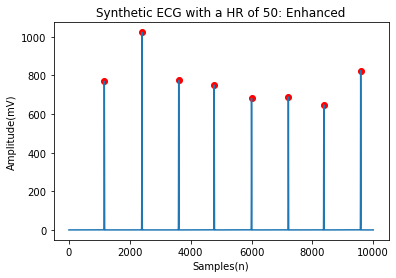

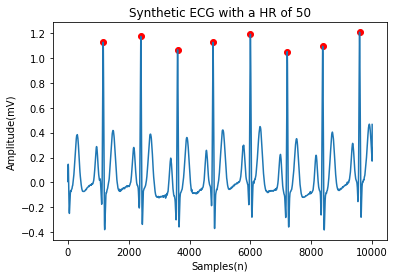

In [173]:
plt.plot(filtered50)
plt.title('Synthetic ECG with a HR of 50: Enhanced')
plt.xlabel('Samples(n)')
plt.ylabel('Amplitude(mV)')
plt.scatter(peaks['x_values'],peaks['y_values'],marker='o',c='red')
plt.show()

y_values = []
for point in peaks['x_values']:
    if point > 0:
        y_values.append(ecg50[point])

plt.plot(ecg50)
plt.title('Synthetic ECG with a HR of 50')
plt.xlabel('Samples(n)')
plt.ylabel('Amplitude(mV)')
plt.scatter(peaks['x_values'],y_values,marker='o',c='red')
plt.show()

In [174]:
filtered80 = _filtering(ecg80,1000)
peaks = _peakdetection(filtered80)
print(peaks)

    x_values     y_values
0        736   764.102593
1       1490   985.688436
2       2257  1023.465075
3       3010   718.358301
4       3743     4.491405
5       4487   882.427916
6       5245   910.680385
7       6010  1024.000000
8       6761   876.746502
9       7500   734.358758
10      8240   757.266629
11      8991   788.005338
12      9745   931.743410


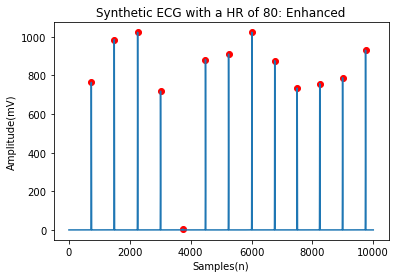

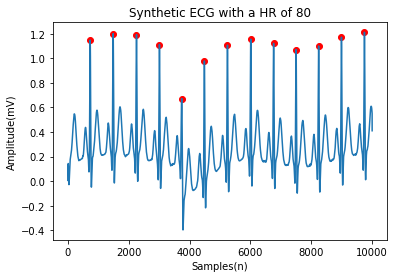

In [175]:
plt.plot(filtered80)
plt.title('Synthetic ECG with a HR of 80: Enhanced')
plt.xlabel('Samples(n)')
plt.ylabel('Amplitude(mV)')
plt.scatter(peaks['x_values'],peaks['y_values'],marker='o',c='red')
plt.show()

y_values = []
for point in peaks['x_values']:
    y_values.append(ecg80[point])

plt.plot(ecg80)
plt.title('Synthetic ECG with a HR of 80')
plt.xlabel('Samples(n)')
plt.ylabel('Amplitude(mV)')
plt.scatter(peaks['x_values'],y_values,marker='o',c='red')
plt.show()

In [176]:
filtered100 = _filtering(ecg100,1000)
peaks = _peakdetection(filtered100)
print(peaks)

    x_values     y_values
0        600   887.745652
1       1200   903.591953
2       1801   966.848915
3       2398   741.166522
4       2993   726.268160
5       3587   840.349474
6       4187   927.726068
7       4794  1007.057876
8       5403   990.499667
9       6006   786.455161
10      6600   690.098294
11      7190   702.448396
12      7787   842.643301
13      8392  1024.000000
14      9002  1023.721810
15      9606   789.785180


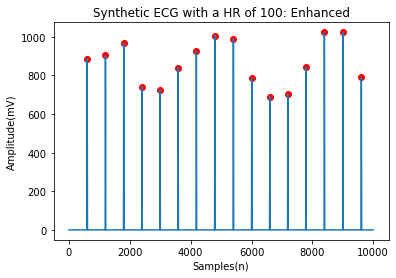

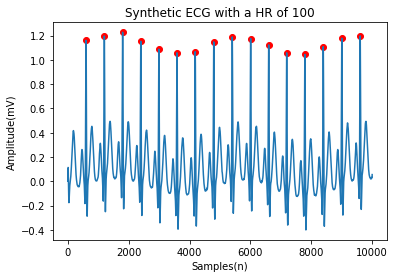

In [177]:
plt.plot(filtered100) 
plt.title('Synthetic ECG with a HR of 100: Enhanced')
plt.xlabel('Samples(n)')
plt.ylabel('Amplitude(mV)')
plt.scatter(peaks['x_values'],peaks['y_values'],marker='o',c='red')
plt.show()

y_values = []
for point in peaks['x_values']:
    y_values.append(ecg100[point])

plt.plot(ecg100)
plt.title('Synthetic ECG with a HR of 100')
plt.xlabel('Samples(n)')
plt.ylabel('Amplitude(mV)')
plt.scatter(peaks['x_values'],y_values,marker='o',c='red')
plt.show()

In [178]:
# We generate three different synthethic ECG signals, with different ammounts of noise. Library: neurokit2

ecg50 = nk.ecg_simulate(duration=10, sampling_rate=1000, heart_rate=50, noise=0.4) # No noise, HR:50
ecg80 = nk.ecg_simulate(duration=10, sampling_rate=1000, heart_rate=80, noise=0.2) # No noise, HR:80
ecg100 = nk.ecg_simulate(duration=10, sampling_rate=1000, heart_rate=100, noise=0.15) # No noise, HR:100

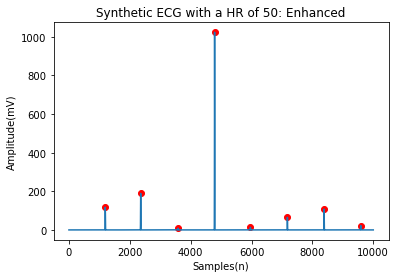

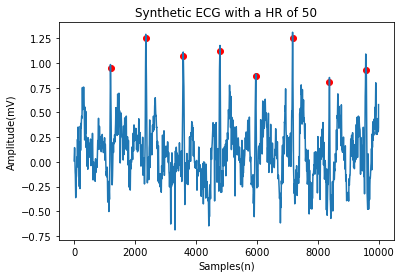

In [179]:
filtered50 = _filtering(ecg50,1000)
peaks = _peakdetection(filtered50)

plt.plot(filtered50)
plt.title('Synthetic ECG with a HR of 50: Enhanced')
plt.xlabel('Samples(n)')
plt.ylabel('Amplitude(mV)')
plt.scatter(peaks['x_values'],peaks['y_values'],marker='o',c='red')
plt.show()

y_values = []
for point in peaks['x_values']:
    if point > 0:
        y_values.append(ecg50[point])

plt.plot(ecg50)
plt.title('Synthetic ECG with a HR of 50')
plt.xlabel('Samples(n)')
plt.ylabel('Amplitude(mV)')
plt.scatter(peaks['x_values'],y_values,marker='o',c='red')
plt.show()

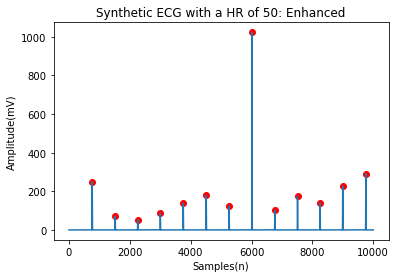

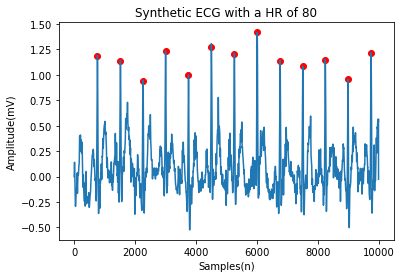

In [180]:
filtered80 = _filtering(ecg80,1000)
peaks = _peakdetection(filtered80)

plt.plot(filtered80)
plt.title('Synthetic ECG with a HR of 50: Enhanced')
plt.xlabel('Samples(n)')
plt.ylabel('Amplitude(mV)')
plt.scatter(peaks['x_values'],peaks['y_values'],marker='o',c='red')
plt.show()

y_values = []
for point in peaks['x_values']:
    if point > 0:
        y_values.append(ecg80[point])

plt.plot(ecg80)
plt.title('Synthetic ECG with a HR of 80')
plt.xlabel('Samples(n)')
plt.ylabel('Amplitude(mV)')
plt.scatter(peaks['x_values'],y_values,marker='o',c='red')
plt.show()

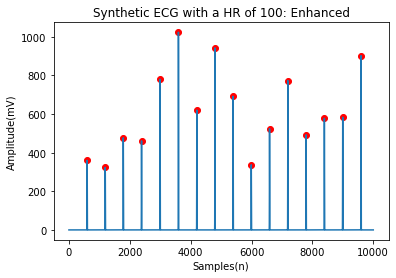

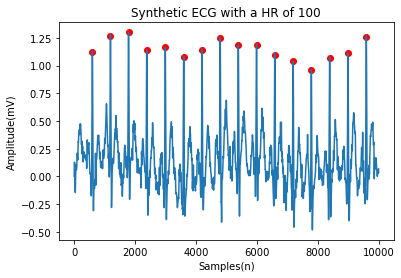

In [181]:
filtered100 = _filtering(ecg100,1000)
peaks = _peakdetection(filtered100)

plt.plot(filtered100)
plt.title('Synthetic ECG with a HR of 100: Enhanced')
plt.xlabel('Samples(n)')
plt.ylabel('Amplitude(mV)')
plt.scatter(peaks['x_values'],peaks['y_values'],marker='o',c='red')
plt.show()

y_values = []
for point in peaks['x_values']:
    if point > 0:
        y_values.append(ecg100[point])

plt.plot(ecg100)
plt.title('Synthetic ECG with a HR of 100')
plt.xlabel('Samples(n)')
plt.ylabel('Amplitude(mV)')
plt.scatter(peaks['x_values'],y_values,marker='o',c='red')
plt.show()

In [182]:
# We generate a different synthethic ECG signals. HR devitations and randmoness added. Inverted Peaks. Library: neurokit2

ecg50 = nk.ecg_simulate(duration=30, length=None, sampling_rate=1000, noise=0.21, heart_rate=70, heart_rate_std=10, method='ecgsyn', random_state=20)

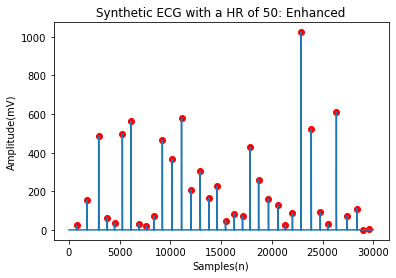

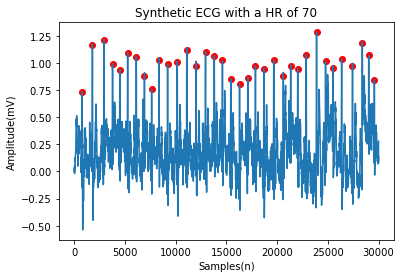

In [183]:
filtered50 = _filtering(ecg50,1000)
peaks = _peakdetection(filtered50)

plt.plot(filtered50)
plt.title('Synthetic ECG with a HR of 50: Enhanced')
plt.xlabel('Samples(n)')
plt.ylabel('Amplitude(mV)')
plt.scatter(peaks['x_values'],peaks['y_values'],marker='o',c='red')
plt.show()

y_values = []
for point in peaks['x_values']:
    if point > 0:
        y_values.append(ecg50[point])

plt.plot(ecg50)
plt.title('Synthetic ECG with a HR of 70')
plt.xlabel('Samples(n)')
plt.ylabel('Amplitude(mV)')
plt.scatter(peaks['x_values'],y_values,marker='o',c='red')
plt.show()

In [184]:
# We generate three different synthethic ECG signals. Inverted Peaks. Library: neurokit2

ecg50 = nk.ecg_simulate(duration=10, sampling_rate=1000, heart_rate=50) # No noise, HR:50
ecg50 = ecg50*(-1)

ecg80 = nk.ecg_simulate(duration=10, sampling_rate=1000, heart_rate=80) # No noise, HR:80
ecg80 = ecg80*(-1)

ecg100 = nk.ecg_simulate(duration=10, sampling_rate=1000, heart_rate=100) # No noise, HR:100
ecg100 = ecg100*(-1)

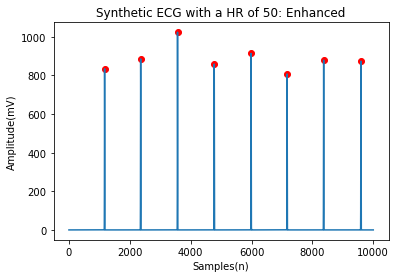

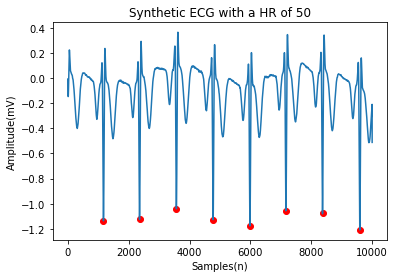

In [185]:
filtered50 = _filtering(ecg50,1000)
peaks = _peakdetection(filtered50)

plt.plot(filtered50)
plt.title('Synthetic ECG with a HR of 50: Enhanced')
plt.xlabel('Samples(n)')
plt.ylabel('Amplitude(mV)')
plt.scatter(peaks['x_values'],peaks['y_values'],marker='o',c='red')
plt.show()

y_values = []
for point in peaks['x_values']:
    if point > 0:
        y_values.append(ecg50[point])

plt.plot(ecg50)
plt.title('Synthetic ECG with a HR of 50')
plt.xlabel('Samples(n)')
plt.ylabel('Amplitude(mV)')
plt.scatter(peaks['x_values'],y_values,marker='o',c='red')
plt.show()

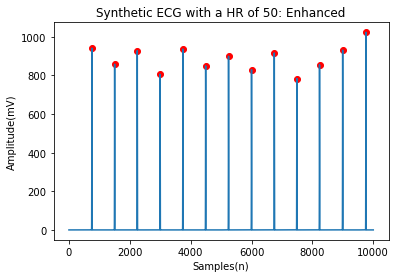

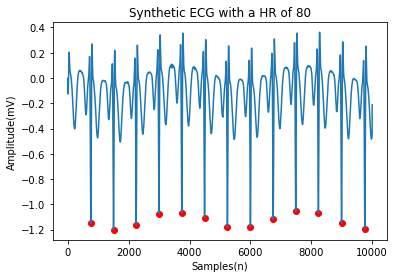

In [186]:
filtered80 = _filtering(ecg80,1000)
peaks = _peakdetection(filtered80)

plt.plot(filtered80)
plt.title('Synthetic ECG with a HR of 50: Enhanced')
plt.xlabel('Samples(n)')
plt.ylabel('Amplitude(mV)')
plt.scatter(peaks['x_values'],peaks['y_values'],marker='o',c='red')
plt.show()

y_values = []
for point in peaks['x_values']:
    if point > 0:
        y_values.append(ecg80[point])

plt.plot(ecg80)
plt.title('Synthetic ECG with a HR of 80')
plt.xlabel('Samples(n)')
plt.ylabel('Amplitude(mV)')
plt.scatter(peaks['x_values'],y_values,marker='o',c='red')
plt.show()

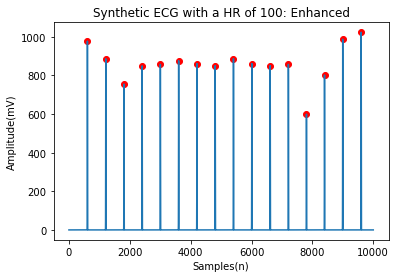

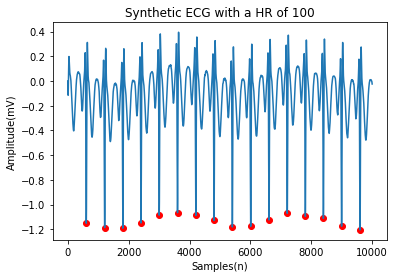

In [187]:
filtered100 = _filtering(ecg100,1000)
peaks = _peakdetection(filtered100)

plt.plot(filtered100)
plt.title('Synthetic ECG with a HR of 100: Enhanced')
plt.xlabel('Samples(n)')
plt.ylabel('Amplitude(mV)')
plt.scatter(peaks['x_values'],peaks['y_values'],marker='o',c='red')
plt.show()

y_values = []
for point in peaks['x_values']:
    if point > 0:
        y_values.append(ecg100[point])

plt.plot(ecg100)
plt.title('Synthetic ECG with a HR of 100')
plt.xlabel('Samples(n)')
plt.ylabel('Amplitude(mV)')
plt.scatter(peaks['x_values'],y_values,marker='o',c='red')
plt.show()

In [188]:
# We generate three different synthethic ECG signals. Random baselines added. Library: neurokit2

ecg50 = nk.ecg_simulate(duration=10, sampling_rate=1000, heart_rate=50) # No noise, HR:50
ecg50 = [i+np.random.rand() for i in ecg50]

ecg80 = nk.ecg_simulate(duration=10, sampling_rate=1000, heart_rate=80) # No noise, HR:80
ecg80 = [i+np.random.rand() for i in ecg80]

ecg100 = nk.ecg_simulate(duration=10, sampling_rate=1000, heart_rate=100) # No noise, HR:100
ecg100 = [i+np.random.rand() for i in ecg100]

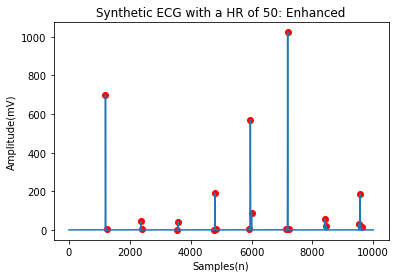

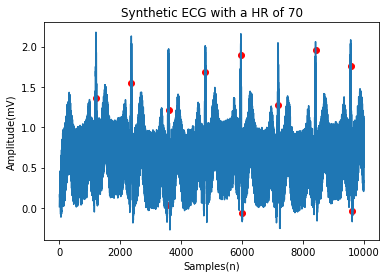

In [189]:
filtered50 = _filtering(ecg50,1000)
peaks = _peakdetection(filtered50)

plt.plot(filtered50)
plt.title('Synthetic ECG with a HR of 50: Enhanced')
plt.xlabel('Samples(n)')
plt.ylabel('Amplitude(mV)')
plt.scatter(peaks['x_values'],peaks['y_values'],marker='o',c='red')
plt.show()

y_values = []
for point in peaks['x_values']:
    if point > 0:
        y_values.append(ecg50[point])

plt.plot(ecg50)
plt.title('Synthetic ECG with a HR of 70')
plt.xlabel('Samples(n)')
plt.ylabel('Amplitude(mV)')
plt.scatter(peaks['x_values'],y_values,marker='o',c='red')
plt.show()

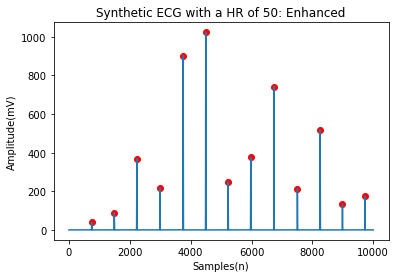

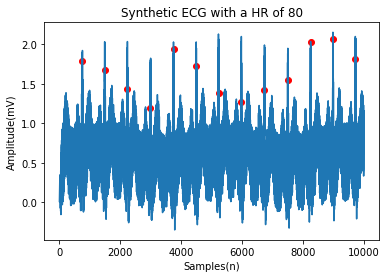

In [190]:
filtered80 = _filtering(ecg80,1000)
peaks = _peakdetection(filtered80)

plt.plot(filtered80)
plt.title('Synthetic ECG with a HR of 50: Enhanced')
plt.xlabel('Samples(n)')
plt.ylabel('Amplitude(mV)')
plt.scatter(peaks['x_values'],peaks['y_values'],marker='o',c='red')
plt.show()

y_values = []
for point in peaks['x_values']:
    if point > 0:
        y_values.append(ecg80[point])

plt.plot(ecg80)
plt.title('Synthetic ECG with a HR of 80')
plt.xlabel('Samples(n)')
plt.ylabel('Amplitude(mV)')
plt.scatter(peaks['x_values'],y_values,marker='o',c='red')
plt.show()

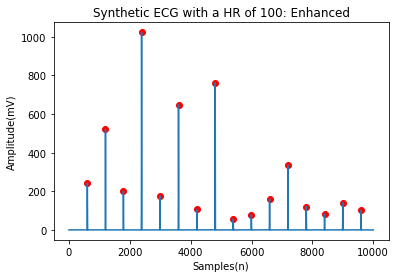

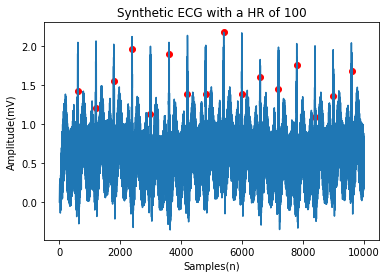

In [191]:
filtered100 = _filtering(ecg100,1000)
peaks = _peakdetection(filtered100)

plt.plot(filtered100)
plt.title('Synthetic ECG with a HR of 100: Enhanced')
plt.xlabel('Samples(n)')
plt.ylabel('Amplitude(mV)')
plt.scatter(peaks['x_values'],peaks['y_values'],marker='o',c='red')
plt.show()

y_values = []
for point in peaks['x_values']:
    if point > 0:
        y_values.append(ecg100[point])

plt.plot(ecg100)
plt.title('Synthetic ECG with a HR of 100')
plt.xlabel('Samples(n)')
plt.ylabel('Amplitude(mV)')
plt.scatter(peaks['x_values'],y_values,marker='o',c='red')
plt.show()

(0.0, 5000.0, -1000.0, 2000.0)

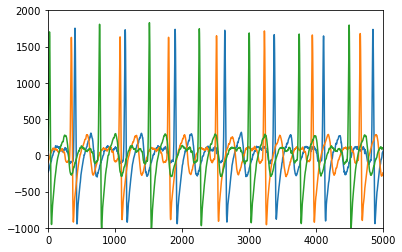

In [192]:
# We try the algorithm with our own data.

ecg_data = pd.read_csv ('./database/new_ecg_data/small_sample.csv')
control_data = ecg_data['Control'].tolist()
diabetic_1 = ecg_data['Diabetic_1'].tolist()
diabetic_2 = ecg_data['Diabetic_2'].tolist()
sr = 1000

plt.plot(control_data)
plt.plot(diabetic_1)
plt.plot(diabetic_2)
plt.axis([0, 5000, -1000, 2000])



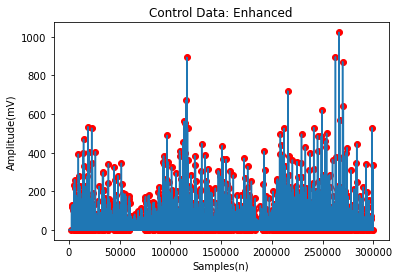

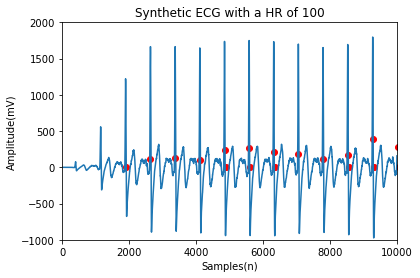

In [194]:
control = _filtering(control_data,1000)
peaks = _peakdetection(control)

plt.plot(control)
plt.title('Control Data: Enhanced')
plt.xlabel('Samples(n)')
plt.ylabel('Amplitude(mV)')
plt.scatter(peaks['x_values'],peaks['y_values'],marker='o',c='red')
plt.show()

y_values = []
for point in peaks['x_values']:
    if point > 0:
        y_values.append(control[point])

plt.plot(control_data)
plt.title('Synthetic ECG with a HR of 100')
plt.xlabel('Samples(n)')
plt.ylabel('Amplitude(mV)')
plt.scatter(peaks['x_values'],y_values,marker='o',c='red')
plt.axis([0, 10000, -1000, 2000])
plt.show()

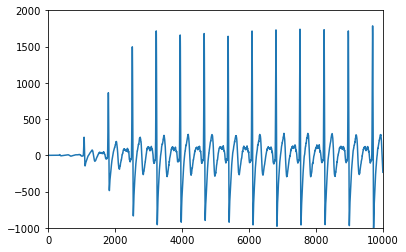

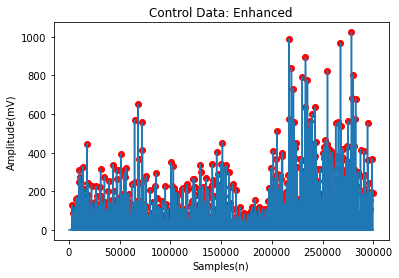

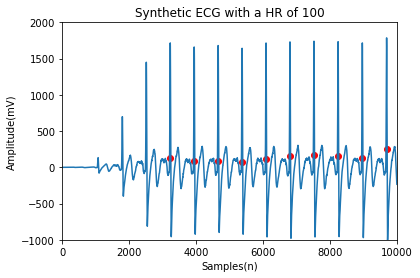

In [168]:
control = _filtering(diabetic_1,1000)
peaks = _peakdetection(control)

plt.plot(control)
plt.title('Control Data: Enhanced')
plt.xlabel('Samples(n)')
plt.ylabel('Amplitude(mV)')
plt.scatter(peaks['x_values'],peaks['y_values'],marker='o',c='red')
plt.show()

y_values = []
for point in peaks['x_values']:
    if point > 0:
        y_values.append(control[point])

plt.plot(diabetic_1)
plt.title('Synthetic ECG with a HR of 100')
plt.xlabel('Samples(n)')
plt.ylabel('Amplitude(mV)')
plt.scatter(peaks['x_values'],y_values,marker='o',c='red')
plt.axis([0, 10000, -1000, 2000])
plt.show()